<a href="https://colab.research.google.com/github/converges/ML-undergraduate/blob/main/Scratch_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 변이형 오토인코더 - 손글씨 MNIST

>작성일: Nov 13, 2023

> [Ref] [만들면서 배우는 생성 AI 2판](https://github.com/rickiepark/Generative_Deep_Learning_2nd_Edition/tree/main/notebooks/03_vae/02_vae_fashion)

이 노트북에서는 패션 MNIST 데이터셋으로 변이형 오토인코더를 훈련합니다.

In [2]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-11-13 01:51:22--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-11-13 01:51:22 (36.8 MB/s) - ‘utils.py’ saved [771/771]



이 코드는 케라스 웹 사이트에 있는 프랑소와 숄레(Francois Chollet)가 만든 훌륭한 [VAE 튜토리얼](https://keras.io/examples/generative/vae/)을 참고했습니다.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets, ## 새주석: (MNIST) 데이터셋 가져오는 라이브러리
    callbacks,
    losses,
    optimizers,
    metrics,
)


from scipy.stats import norm

from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [20]:
IMAGE_SIZE = 32 ## 새주석: 다운받은 이미지 사이즈는 28
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10 ## 새주석: epoch 5->10
BETA = 500

## 1. 데이터 준비 <a name="prepare"></a>

In [21]:
# 데이터 로드
## 새주석: MNIST 데이터셋 가져오기
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [22]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) # 이미지 사이즈 28->32
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

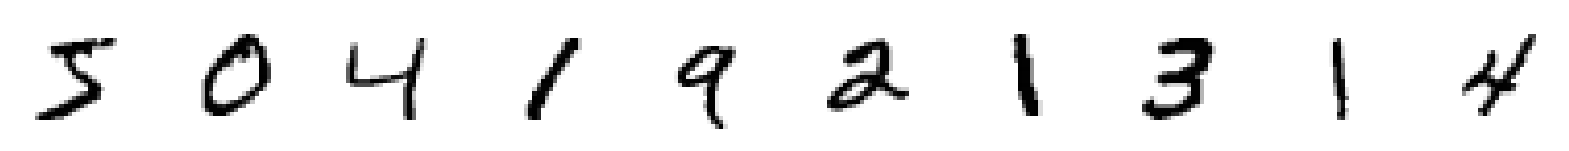

In [23]:
# 훈련 세트의 일부 확인
display(x_train)

## 2. 변이형 오토인코더 만들기 <a name="build"></a>

In [24]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [25]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [26]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [27]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [28]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

## 3. 변이형 오토인코더 훈련 <a name="train"></a>

In [29]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [30]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [31]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10
599/600 [============================>.] - ETA: 0s - total_loss: 105.6928 - reconstruction_loss: 102.7326 - kl_loss: 2.9601

600/600 [==============================] - 22s 14ms/step - total_loss: 105.6562 - reconstruction_loss: 102.6946 - kl_loss: 2.9614 - val_loss: 84.5514 - val_reconstruction_loss: 80.9126 - val_kl_loss: 3.6388
Epoch 2/10
599/600 [============================>.] - ETA: 0s - total_loss: 83.1269 - reconstruction_loss: 79.1911 - kl_loss: 3.9359

600/600 [==============================] - 7s 11ms/step - total_loss: 83.1287 - reconstruction_loss: 79.1925 - kl_loss: 3.9362 - val_loss: 79.7729 - val_reconstruction_loss: 75.5717 - val_kl_loss: 4.2012
Epoch 3/10
598/600 [============================>.] - ETA: 0s - total_loss: 80.5369 - reconstruction_loss: 76.1832 - kl_loss: 4.3537

600/600 [==============================] - 7s 11ms/step - total_loss: 80.5479 - reconstruction_loss: 76.1936 - kl_loss: 4.3543 - val_loss: 77.1922 - val_reconstruction_loss: 72.6941 - val_kl_loss: 4.4981
Epoch 4/10
600/600 [==============================] - ETA: 0s - total_loss: 79.2913 - reconstruction_loss: 74.7364 - kl_loss: 4.5549

600/600 [==============================] - 7s 11ms/step - total_loss: 79.2913 - reconstruction_loss: 74.7364 - kl_loss: 4.5549 - val_loss: 77.5115 - val_reconstruction_loss: 72.8598 - val_kl_loss: 4.6517
Epoch 5/10
596/600 [============================>.] - ETA: 0s - total_loss: 78.4404 - reconstruction_loss: 73.7555 - kl_loss: 4.6850

600/600 [==============================] - 7s 12ms/step - total_loss: 78.4347 - reconstruction_loss: 73.7490 - kl_loss: 4.6857 - val_loss: 76.9989 - val_reconstruction_loss: 72.0367 - val_kl_loss: 4.9623
Epoch 6/10
598/600 [============================>.] - ETA: 0s - total_loss: 77.7949 - reconstruction_loss: 73.0090 - kl_loss: 4.7859

600/600 [==============================] - 7s 12ms/step - total_loss: 77.8012 - reconstruction_loss: 73.0153 - kl_loss: 4.7859 - val_loss: 76.0499 - val_reconstruction_loss: 71.1420 - val_kl_loss: 4.9080
Epoch 7/10
596/600 [============================>.] - ETA: 0s - total_loss: 77.2991 - reconstruction_loss: 72.4165 - kl_loss: 4.8826

600/600 [==============================] - 7s 12ms/step - total_loss: 77.2936 - reconstruction_loss: 72.4116 - kl_loss: 4.8819 - val_loss: 75.8402 - val_reconstruction_loss: 70.9266 - val_kl_loss: 4.9136
Epoch 8/10
600/600 [==============================] - ETA: 0s - total_loss: 76.8509 - reconstruction_loss: 71.8998 - kl_loss: 4.9511

600/600 [==============================] - 7s 12ms/step - total_loss: 76.8509 - reconstruction_loss: 71.8998 - kl_loss: 4.9511 - val_loss: 75.9178 - val_reconstruction_loss: 70.6344 - val_kl_loss: 5.2834
Epoch 9/10
598/600 [============================>.] - ETA: 0s - total_loss: 76.5024 - reconstruction_loss: 71.4927 - kl_loss: 5.0096

600/600 [==============================] - 7s 11ms/step - total_loss: 76.5007 - reconstruction_loss: 71.4911 - kl_loss: 5.0096 - val_loss: 75.9977 - val_reconstruction_loss: 70.9595 - val_kl_loss: 5.0381
Epoch 10/10
596/600 [============================>.] - ETA: 0s - total_loss: 76.1487 - reconstruction_loss: 71.0884 - kl_loss: 5.0603

600/600 [==============================] - 7s 12ms/step - total_loss: 76.1403 - reconstruction_loss: 71.0804 - kl_loss: 5.0599 - val_loss: 75.0078 - val_reconstruction_loss: 69.8747 - val_kl_loss: 5.1331


In [32]:
# 최종 모델 저장
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. 변이형 오토인코더를 사용한 재구성 <a name="reconstruct"></a>

In [33]:
# 테스트셋의 일부를 선택합니다.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 3ms/step
실제 데이터


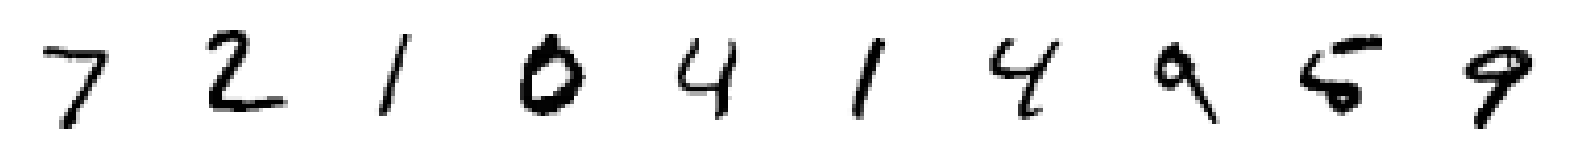

재구성 이미지


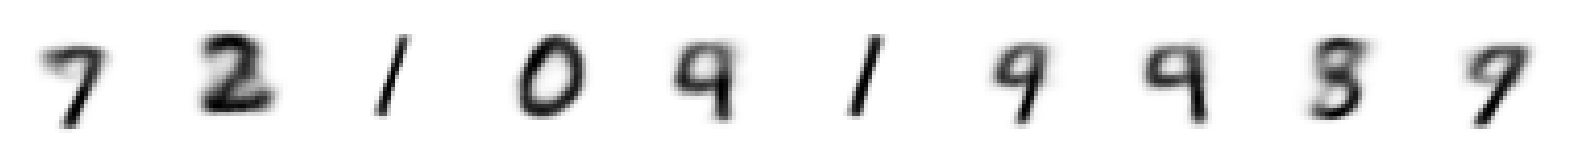

In [44]:
# 오토인코더 예측을 만들고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 데이터")
display(example_images)
print("재구성 이미지")
display(reconstructions)

## 4. 인코더를 사용하여 임베딩하기 <a name="encode"></a>

In [35]:
# 예제 이미지 인코딩
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [36]:
# 임베딩의 몇 가지 예
print(z[:10])

[[ 0.02086989 -1.2607071 ]
 [-0.7728727   0.64625305]
 [ 2.0845098  -1.2361274 ]
 [ 0.558324    1.6107954 ]
 [-1.4680638  -0.5947038 ]
 [ 2.087284   -1.0142353 ]
 [-0.4483174  -0.8811813 ]
 [-1.7192421  -0.7748611 ]
 [-0.16735278 -0.00300026]
 [ 0.4830077  -0.7729821 ]]


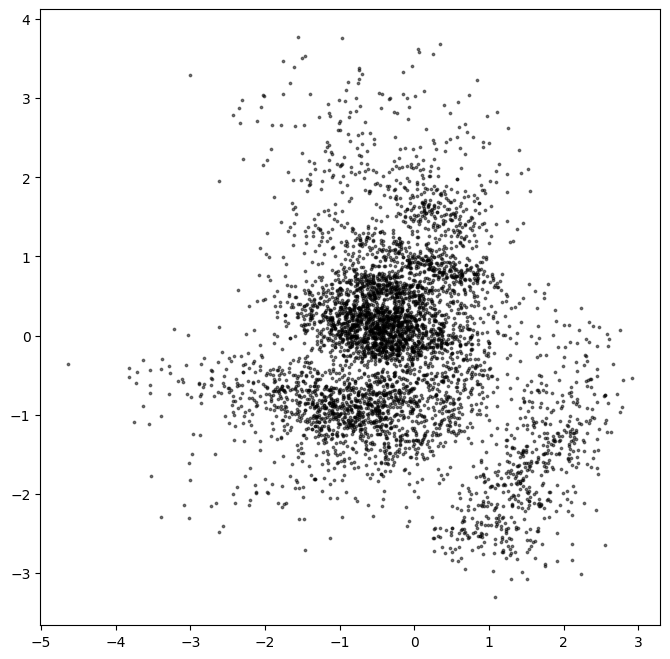

In [37]:
# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. 디코더를 사용하여 생성하기 <a name="decode"></a>

In [38]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [39]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 205ms/step


In [40]:
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

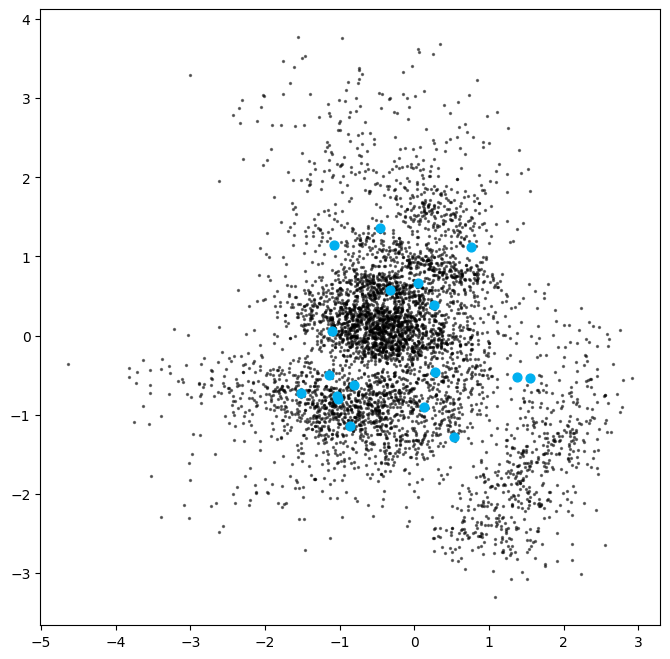

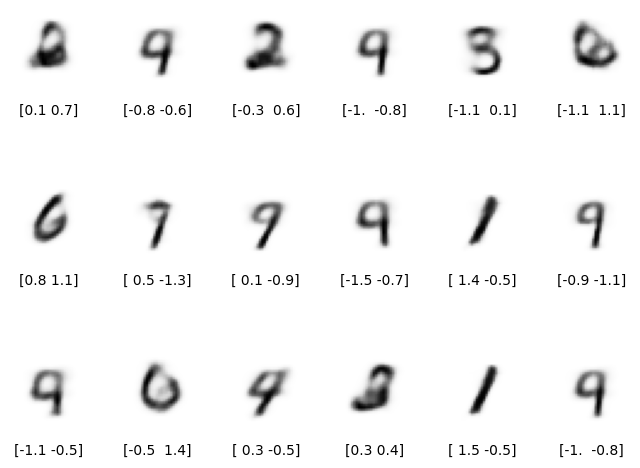

In [41]:
# 그래프를 그립니다....
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드를 추가합니다.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. 잠재 공간 탐색 <a name="explore"></a>

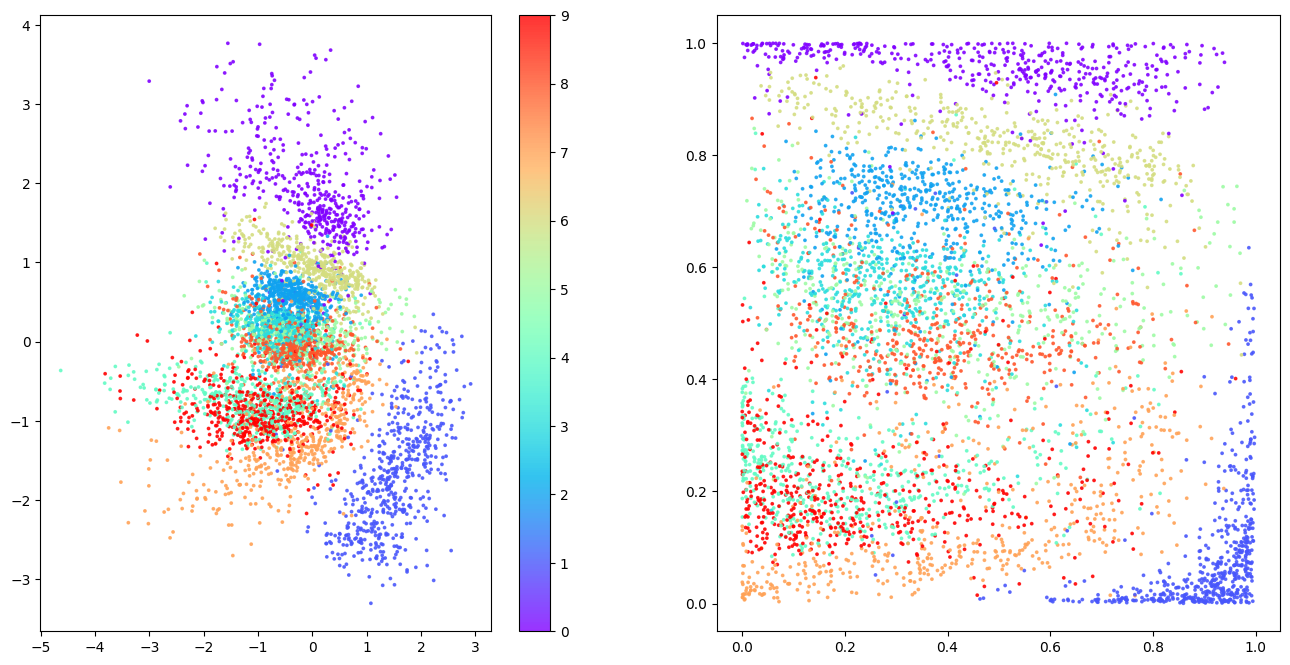

In [42]:
# 레이블(숫자)에 따라 임베딩에 색상을 지정합니다.
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 11ms/step


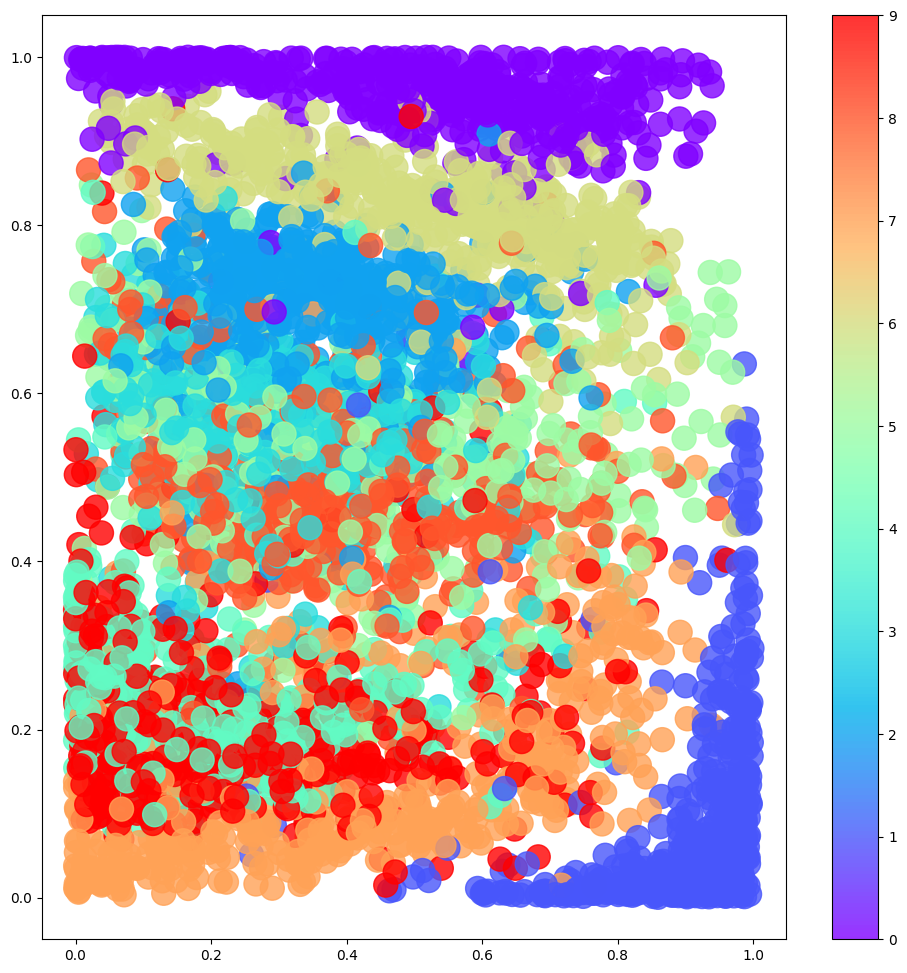

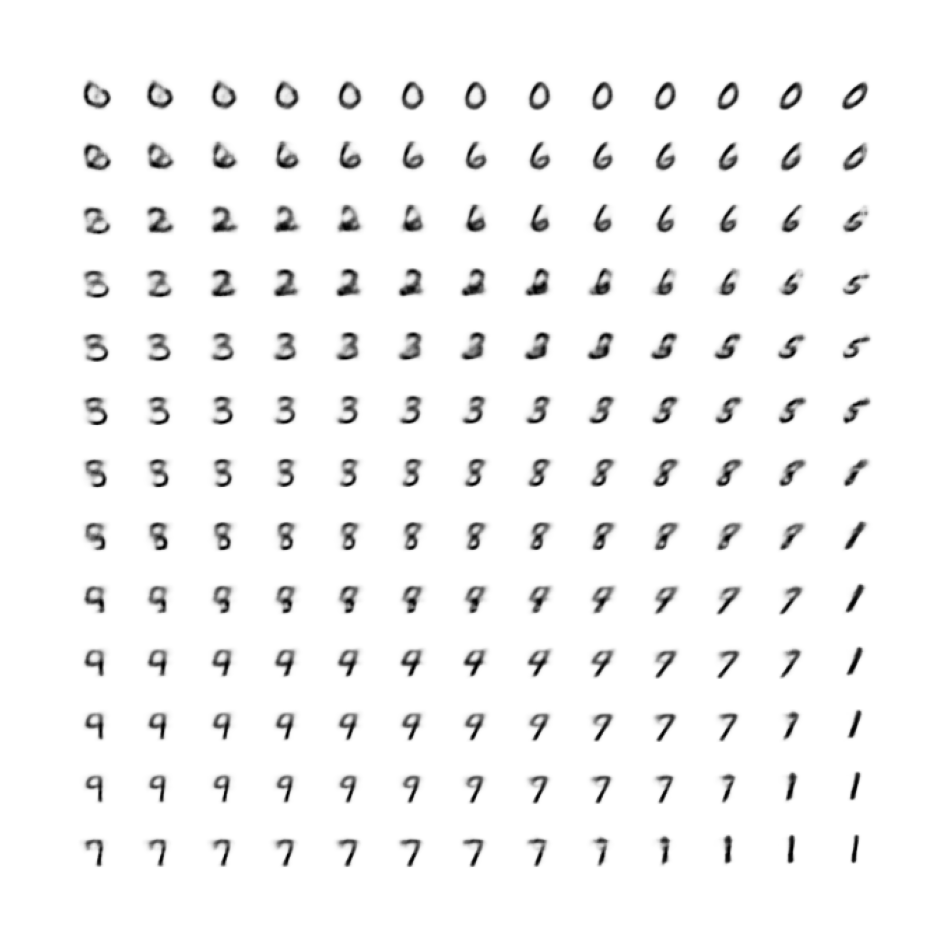

In [43]:
# 레이블(숫자)에 따라 임베딩에 색상을 지정합니다.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter( ## 새주석: 개수만큼 된다
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")